In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, warnings
import datetime as dt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import seaborn as sns

sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)


warnings.filterwarnings("ignore")

In [7]:
# read file
data_raw = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str, 'InvoiceNo': str})
# take a peak at structure of raw input
print(data_raw.shape)
print(list(data_raw.columns))
data_raw.head()
print(data_raw.shape)

# time to start cleaning the data
data = data_raw.dropna()
print(data.shape)

# remove returned items
data = data[data['Quantity']>0]
# check for how many were removed
print(data.shape)
#check for dupes
print('duplicate entries: {}'.format(data.duplicated().sum()))

# take a look at value counts
pd.DataFrame([{'products': len(data['StockCode'].value_counts()), 'transactions': len(data['InvoiceNo'].value_counts()), 'customers': len(data['CustomerID'].value_counts()), }], columns = ['products', 'transactions', 'customers'])

# now groupby customer to count items per invoice (per order)
tmp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
tmp.head()
number_prod_per_basket = tmp.rename(columns = {'InvoiceDate':'Number_of_products'})
print(number_prod_per_basket[:10].sort_values('CustomerID'))


(541909, 9)
['Unnamed: 0', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
(541909, 9)
(406829, 9)
(397924, 9)
duplicate entries: 0
  CustomerID InvoiceNo  Number_of_products
0    12346.0    541431                   1
1    12347.0    537626                  31
2    12347.0    542237                  29
3    12347.0    549222                  24
4    12347.0    556201                  18
5    12347.0    562032                  22
6    12347.0    573511                  47
7    12347.0    581180                  11
8    12348.0    539318                  17
9    12348.0    541998                   6


<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
recency           4339 non-null int64
frequency         4339 non-null int64
monetary_value    4339 non-null float64
dtypes: float64(1), int64(2)
memory usage: 135.6+ KB
1    2265
0    2074
Name: churned, dtype: int64


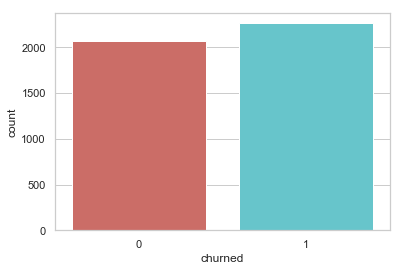

In [2]:
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']
#print(data.sort_values('CustomerID')[:5])
#data.info()


## make RFM categories
# find min and max dates for recency calculations
data['InvoiceDate'].min()
data['InvoiceDate'].max()
final_date_time = dt.datetime(2011,12,10)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# create the RFM table with column names changed from string to more usable things
RFM_table = data.groupby('CustomerID').agg({'InvoiceDate' : lambda x: (final_date_time - x.max()).days, 'InvoiceNo' : lambda x: len(x), 'TotalPrice' : lambda x: x.sum()})
#RFM_table.info()

RFM_table['InvoiceDate'] = RFM_table['InvoiceDate'].astype(int)
RFM_table.rename(columns = {'InvoiceDate' : 'recency', 'InvoiceNo' : 'frequency', 'TotalPrice' : 'monetary_value'}, inplace=True)
RFM_table.info()
#RFM_table.head()

# make quaRtile segments with quaNtile function
quartiles = RFM_table.quantile(q = [0.25, 0.5, 0.75])
quartiles = quartiles.to_dict()

# now make new table with segmented version of original RFM_table
RFM_segments = RFM_table
#RFM_segments.info()
# deine functions to return segment, low = good for recency, low = bad for frequency and monetary_value

def recency_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def freq_and_monetization_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# define function to determine if churned or not. using if customer did or didnt buy in most recent 45 daysself.

def is_churned(x):
    if x <= 45:
        return 0
    else:
        return 1
    
# now make the RFM_segments by applying quartile score functions to the RFM_segments table
RFM_segments['recency_quartile'] = RFM_segments['recency'].apply(recency_score, args = ('recency', quartiles))
RFM_segments['frequency_quartile'] = RFM_segments['frequency'].apply(freq_and_monetization_score, args = ('frequency', quartiles))
RFM_segments['monetary_value_quartile'] = RFM_segments['monetary_value'].apply(freq_and_monetization_score, args = ('monetary_value', quartiles))
RFM_segments['churned'] = RFM_segments['recency'].apply(is_churned)

#RFM_segments.head()

RFM_segments['RFM_score'] = RFM_segments.recency_quartile.map(str) + RFM_segments.frequency_quartile.map(str) + RFM_segments.monetary_value_quartile.map(str)

RFM_segments.head()

print(RFM_segments['churned'].value_counts())

# lets take a look at the churn vs other variables

sns.countplot(x = 'churned', data = RFM_segments, palette='hls')
plt.show()



Text(0,0.5,'monetary_value quartile')

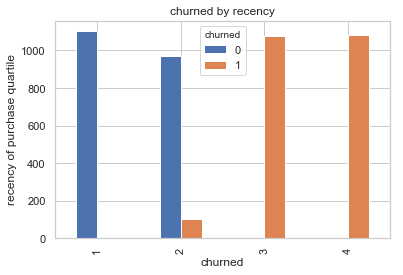

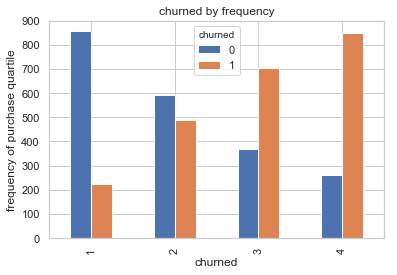

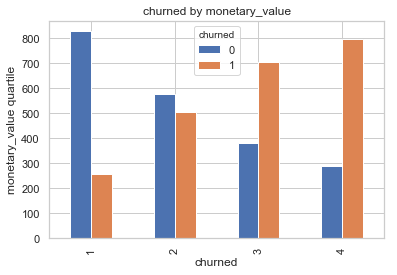

In [3]:
pd.crosstab(RFM_segments.recency_quartile, RFM_segments.churned).plot(kind='bar')
plt.title('churned by recency')
plt.xlabel('churned')
plt.ylabel('recency of purchase quartile')

pd.crosstab(RFM_segments.frequency_quartile, RFM_segments.churned).plot(kind='bar')
plt.title('churned by frequency')
plt.xlabel('churned')
plt.ylabel('frequency of purchase quartile')

pd.crosstab(RFM_segments.monetary_value_quartile, RFM_segments.churned).plot(kind='bar')
plt.title('churned by monetary_value')
plt.xlabel('churned')
plt.ylabel('monetary_value quartile')


Logistic Regression mean absolute error: 0.03
Logistic Regression Score: 0.967741935483871


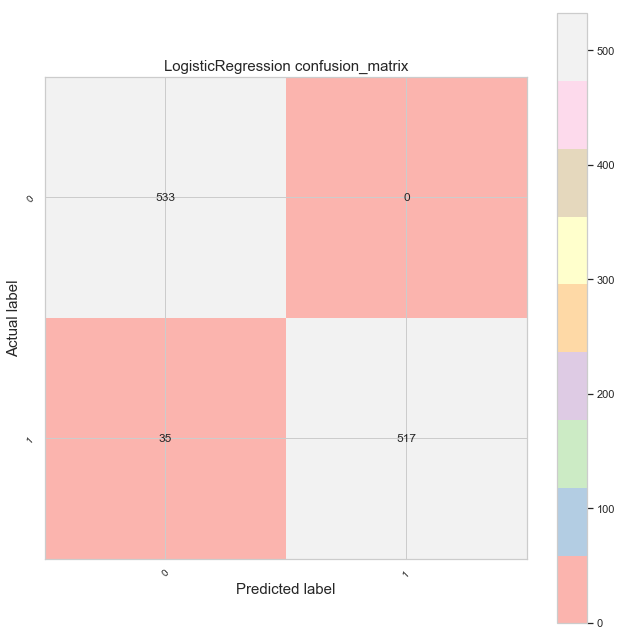

In [10]:
##make LogisticRegression model 
# split train and test data
X = RFM_segments.loc[:,'recency_quartile':'monetary_value_quartile']
y = RFM_segments['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#instantiate LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
log_regr_predictions = logisticRegr.predict(X_test)
log_regr_errors = abs(log_regr_predictions - y_test)
print('Logistic Regression mean absolute error:', round(np.mean(log_regr_errors), 2 ))

print("Logistic Regression Score:", logisticRegr.score(X_test, y_test))

# now for the confusion_matrix of logistic regression
log_regr_cm = metrics.confusion_matrix(y_test, log_regr_predictions)
plt.figure(figsize=(9,9))
plt.imshow(log_regr_cm, interpolation='nearest', cmap='Pastel1')
plt.title('LogisticRegression confusion_matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"], rotation=45, size=10)
plt.yticks(tick_marks, ["0", "1"], rotation=45, size=10)
plt.tight_layout()
plt.ylabel('Actual label', size=15)
plt.xlabel('Predicted label', size=15)
width, height = log_regr_cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(log_regr_cm[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center')


In [5]:
## make random forest model
Rand_For = RandomForestRegressor(n_estimators = 1000, random_state = 42)
Rand_For.fit(X_train, y_train)
rand_for_predictions = Rand_For.predict(X_test)
rand_for_errors = abs(rand_for_predictions - y_test)
print('Random Forest mean absolute error:', round(np.mean(rand_for_errors), 2 ))
print("Random Forest score:", Rand_For.score(X_test, y_test)) 

Random Forest mean absolute error: 0.05
Random Forest score: 0.8884509794158124
